# Data Exploration and Statin Analysis on FHIR
This notebook shows a pattern to make FHIR data work well with the best available analytic tools. We'll use a [new Python library](https://github.com/google/fhir-py) to explore a complex dataset and build a simplified quality measure over it.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/fhir-py/blob/main/examples/statin_analysis_spark_example.ipynb) __(Synthetic data only--not HIPAA compliant)__


## Flattened views of FHIR data
Our approach is centered on creating simple, flat views of FHIR data that fit the problem at hand -- and works well with common analytic tools. This comes in four major parts: _view definitions_, _code value sets_, _view runners_, and of course your favorite analytic tools themselves.

### View definitions
Defines the fields and criteria for a tabular view of a given FHIR resource. Both of these come as [FHIRPath expressions](https://build.fhir.org/fhirpath.html) created with a guided builder in Python, including tab completion so users don't need to remember all of the resource fields for FHIRPath function names.

Here is a simple example of a view. We'll see much more involved examples later in this notebook:

```python
pats = views.view_of('Patient')

simple_patient_view = pats.select({
    'id': pats.id,
    'gender': pats.gender,
    'birthdate': pats.birthDate
    }).where(pats.birthDate < datetime.datetime(1960, 1, 1))
```

### Value set content
Code value sets are key piece of almost any meaningful analysis of healthcare data, so we support both retrieving FHIR value sets from a terminology server and using them in FHIRPath `memberOf` functions to define view columns and filters.

### View runners
A _view runner_ turns a view definition into actual data by querying some FHIR-based data source. In this example we will show the Spark runner. This will include the ability to use FHIR Views on any infrastructure, Google or otherwise.

### Your favorite analytic tools
The final part is your favorite analytic tools. FHIR views defined here simply get data into a tabular table, dataframe, or similar structure. From there users can more easily use analytic capabilities native to the underlying database, programming language, or analytic tools like [Data Studio](https://datastudio.google.com/). Examples of this are below.



## Installation
If you have Python 3.8 or newer installed, this library can by installed from pypi by simply running:

```
pip install google-fhir-views[r4,spark]
```

It's recommended to do so *before* starting the notebook kernel to avoid any dependency version issues. 

If you are running in Vertex AI Workbench with an older version of Python you will need to upgrade then install. This can be done with the following commands in a terminal:


```
conda create -n python310 python=3.10 -y
conda activate python310
conda install ipykernel -y
ipython kernel install --user --name=python310
pip install google-fhir-views[r4,spark]

```

Running the cell below will attempt to install the libraries in your notebook environment, after which you will need to manually restart the kernel.

In [ ]:
!pip install google-fhir-views[r4,spark]
!pip install google-cloud-bigquery

# Setup and Authentication

Users of this notebook will need to have a running
[Hive Thriftserver](https://spark.apache.org/docs/latest/sql-distributed-sql-engine.html#running-the-thrift-jdbcodbc-server)
endpoint to connect to. For this notebook, we run our analysis on exported
Parquet files of the
[Synthea Generated Synthetic Dataset](https://console.cloud.google.com/marketplace/product/mitre/synthea-fhir)
on BigQuery. You will need to assign your GCP user account with the BigQuery
User, BigQuery Data Viewer, and Storage Admin roles to export the files from
BigQuery to your local machine.

**Note**: Parquet files can also be generated directly from FHIR resources using
the [fhir-data-pipes](https://github.com/google/fhir-data-pipes) repository.

If you are using Colab, running the cell below should retrieve your user
credentials:

In [ ]:
if 'google.colab' in str(get_ipython()):
  print('NOTE: COLAB IS NOT HIPAA ELIGIBLE, please only continue with synthetic data.')
  from google.colab import auth
  auth.authenticate_user()
  print('Authenticated')

The cell below exports the synthetic dataset from BigQuery to your GCS bucket:

In [ ]:
from google.cloud import bigquery

# Your project id
project = 'fhir-analytics-test'  # @param {type:"string"}

# The name of your GCS bucket
bucket_name = 'my-bucket'  # @param {type:"string"}

bq_client = bigquery.Client(project)

dataset_ref = bigquery.DatasetReference('bigquery-public-data', 'fhir_synthea')
table_ids_for_export = ['patient', 'condition', 'observation']


for table_id in table_ids_for_export:
  destination_uri = 'gs://{}/{}'.format(bucket_name, f'{table_id}')
  extract_job = bq_client.extract_table(
      source=dataset_ref.table(table_id),
      destination_uris=destination_uri,
      # Source table stored in US location.
      location='US',
      job_config=bigquery.job.ExtractJobConfig(
          destination_format='PARQUET',
          compression='GZIP',
      ),
  )
  extract_job.result()

Tne next cell dowloads the parquet files stored in the GCS bucket to your local machine, so it can be loaded into the local Spark ThriftServer.

In [ ]:
# The path to which the parquet files should be downloaded
destination_directory_path = "/tmp/" #@param {type:"string"}

!gsutil -m cp -r gs://{bucket_name}/* {destination_directory_path}

## Environment setup
This notebook creates Spark views and tables for analysis, and a dataset you can write for the later notebook cells that save data for analysis. This notebook will attempt to create a `statin_analysis_example` dataset if it does not already exist.

The cell below sets up the Spark client and creates a new dataset that will be used for this analysis. It also creates a Spark view "runner", which is used to apply declarative views of FHIR in Spark. Examples of using it are below.

In [ ]:
import pandas

from sqlalchemy import dialects
from sqlalchemy import engine

from google.fhir.views import r4
from google.fhir.views import spark_runner

# The Spark dataset containing FHIR data. This may be read-only to the user.
fhir_dataset = 'default'

# The Spark dataset where we will create views, value sets, and other derived tables
# as needed. This must be writeable by the user. This will use the default project
# where this notebook is running.
analysis_dataset = 'statin_analysis_example'

dialects.registry.register('hive', 'pyhive.sqlalchemy_hive', 'HiveDialect')

# The endpoint of the Hive ThriftServer to connect to
query_engine = engine.create_engine('hive://localhost:10001/default')

# Create a runner to execute the views over Spark.
runner = spark_runner.SparkRunner(
    query_engine=query_engine,
    fhir_dataset=fhir_dataset,
    view_dataset=analysis_dataset,
    snake_case_resource_tables=True,
)

The cell below loads the parquet files we've downloaded into our Spark ThriftServer:

In [ ]:
with query_engine.connect() as curs:
  curs.execute(f'DROP TABLE IF EXISTS {fhir_dataset}.condition;')
  curs.execute(f'DROP TABLE IF EXISTS {fhir_dataset}.medication_request;')
  curs.execute(f'DROP TABLE IF EXISTS {fhir_dataset}.observation;')
  curs.execute(f'DROP TABLE IF EXISTS {fhir_dataset}.patient;')
  curs.execute(
      f'CREATE TABLE IF NOT EXISTS {fhir_dataset}.condition USING PARQUET'
      f" LOCATION '{destination_directory_path}/condition*';"
  )
  curs.execute(
      f'CREATE TABLE IF NOT EXISTS {fhir_dataset}.medication_request USING'
      f" PARQUET LOCATION '{destination_directory_path}/medication_request*';"
  )
  curs.execute(
      f'CREATE TABLE IF NOT EXISTS {fhir_dataset}.observation USING PARQUET'
      f" LOCATION '{destination_directory_path}/observation*';"
  )
  curs.execute(
      f'CREATE TABLE IF NOT EXISTS {fhir_dataset}.patient USING PARQUET'
      f" LOCATION '{destination_directory_path}/patient*';"
  )

  curs.execute(f'DROP DATABASE IF EXISTS {analysis_dataset} CASCADE;')
  curs.execute(f'CREATE DATABASE IF NOT EXISTS {analysis_dataset};')

# Explore the data
Getting a general feeling for the data is an important first step in any analysis. So let's create some views of FHIR resources and take a look at common fields. Note that the results of this notebook are very similar to the BigQuery notebook. Being able to define views independent of the runner is one of the main advantages of using FHIR Views.

In [ ]:
# Load views based on the base FHIR R4 profile definitions.
views = r4.base_r4()

# Create shorthand names for resources we will work with.
conds = views.view_of('Condition')
meds = views.view_of('MedicationRequest')
obs = views.view_of('Observation')
pats = views.view_of('Patient')

Let's take a look at some observation resources by creating FHIRPath expressions to select the items we're interested in.

Notice that tab completion works for FHIR fields and FHIRPath functions, so users don't need to switch back and forth to FHIR documentation as much.


In [ ]:
runner.to_dataframe(
    obs.select({
        'category': obs.category.coding.code,
        'code_display': obs.code.coding.display,
        'status': obs.status,
    }),
    limit=5,
)

Of course just a sample of codes isn't too useful -- we really want a summary of what codes exist in a field and how many there are. Fortunately, the Spark runner supports a `summarize_codes` method that accepts a view and a field name and does exactly that.

Also notice this handles many millions of records in seconds thanks to the underlying Spark execution engine.

In [ ]:
runner.summarize_codes(obs, obs.category)

We can also do so for conditions or other resources:

In [ ]:
runner.summarize_codes(conds, conds.code)

# Creating Views
FHIR Data is complicated, but there is usually a flat, tabular form of it that can satisfy a given use case and data set.

For example, imagine we need a simple table of patients with their current address. This isn't trivial to query since the address is a nested repeated field. Fortunately we can build a FHIRPath expression to find the current address and create a flattened view using that. 

(This can vary by dataset, but in this case we determine the current address by finding the first address that does not have a period attached to it.)

In [ ]:
# For this dataset we interpret the current address as one where period is empty.

current = pats.address.where(pats.address.period.empty()).first()

simple_pats = pats.select({
    'id': pats.id,
    'gender': pats.gender,
    'birthdate': pats.birthDate,
    'street': current.line.first(),
    'city': current.city,
    'state': current.state,
    'zip': current.postalCode,
})

runner.to_dataframe(simple_pats, limit=5)

That's nice, but suppose we want to create it as an actual Spark view -- basically a virtual table that can be easily used by *any* application that uses Spark. We can simply turn that definition into a Spark view: *italicized text*

In [ ]:
runner.create_database_view(simple_pats, 'patients')

In [ ]:
pandas.read_sql_query(
    sql='SELECT * FROM statin_analysis_example.patients LIMIT 5',
    con=query_engine,
)

Now we have a nice, flattened patients table that meets the needs of our system and data. We'll create similarly simple views of other resources as well, but first we need to introduce another concept: value sets. 

# Using Value Sets
Code value sets are a central part of nearly any significant FHIR-based data analysis. For instance, the car gap analysis below needs to query for statin medications, LDL tests, and other concepts. Users could track down specific code values, but there's a better way: we will use predefined, curated value sets from the [Value Set Authority Center](https://vsac.nlm.nih.gov/) that define this content.

Here's an example search for LDL codes to use in our analysis:

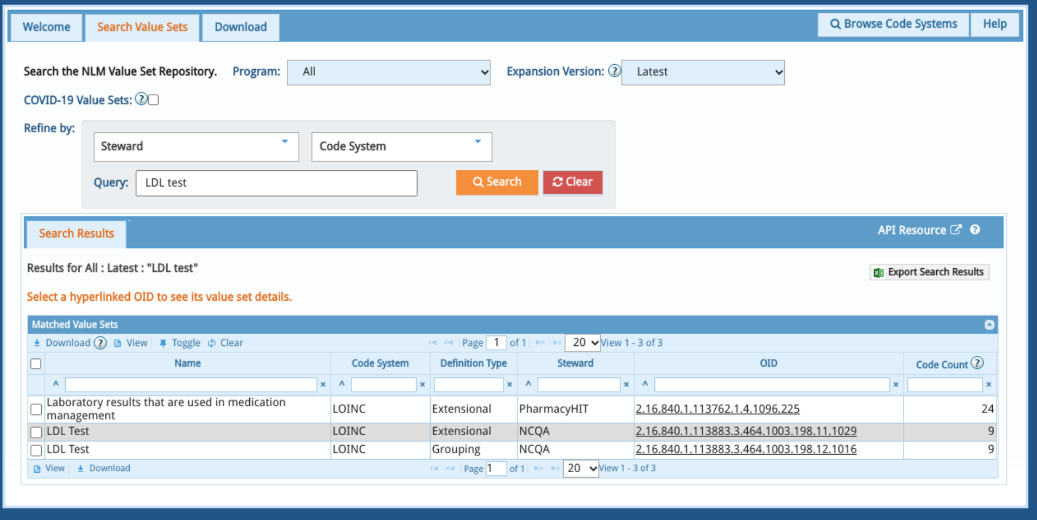

First we need to obtain the content. Users may create a value set table themselves and populate it as needed, but this library also supports the ability to connect to a FHIR terminology server and retrieve the needed values. The example below shows connecting to VSAC's terminology server and getting code values for statins, CHD, and LDL tests:

In [ ]:
# Value set URLs used in the queries
STATIN_MEDS = (
    'http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840.1.113883.3.117.1.7.1.225'
)
CHD_OR_RISK_EQUIV = (
    'http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840.1.113883.3.600.862'
)
LDL_TEST = 'http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840.1.113883.3.464.1003.198.11.1029'

In [ ]:
import getpass
from google.fhir.r4.terminology import terminology_service_client

api_key = getpass.getpass('UMLS API KEY: ')

tx_client = terminology_service_client.TerminologyServiceClient({
    'http://cts.nlm.nih.gov/fhir/': ('apikey', api_key),
})
runner.materialize_value_set_expansion((STATIN_MEDS, LDL_TEST, CHD_OR_RISK_EQUIV), tx_client)

Now that we've downloaded that content, let's take a look at the value_set_codes table it produced:

In [ ]:
pandas.read_sql_query(
    sql="""
    SELECT * FROM  default.value_set_codes
    WHERE valueseturi = 'http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840.1.113883.3.464.1003.198.11.1029'
    """,
    con=query_engine,
)

We now have the value sets needed for some analysis stored in Spark, so let's use them for an important use case: identifying gaps in care.


# Identifying Statin Therapy Care Gaps
This section analyzes the use of statin therapy for patients who have been diagnosed with Coronary Heart Disease (CHD) or have equivalent risks. We achieve this by first identifying a cohort of patients and then measuring the percentage of them with the recommended therapy. 

Some of this content is based on the [Statin Therapy eCQM](https://ecqi.healthit.gov/system/files/ecqm/measures/CMS347v1.html).

## The cohort:
Patients who have either of the following during the measurement period:
* Coronary Heart Disease or equivalent risks (as defiend by CMS) OR
* An LDL-C greater than or equal to 180

## The measure:
The percentage of cohort members who have statin therapy. Let's take the complex FHIR data and create some simple views for our needs, starting with a view of all LDL values:



In [ ]:
ldl_obs = obs.select({
    'patient': obs.subject.getReferenceKey('Patient'),
    'value': obs.value.ofType('Quantity').value,
    'unit': obs.value.ofType('Quantity').unit,
    'test': obs.code.coding.display.first(),
    'effectiveTime': obs.effective.ofType('dateTime'),
}).where(obs.code.memberOf(LDL_TEST))

runner.to_dataframe(ldl_obs, limit=10)

Now we can create it as a Spark view -- and *all* analysis that needs LDL values can simply use this nice, flattened table for that use case.

We recommend creating such simple, flattened tables for each major part of your analysis. That way they can be inspected and validated independently of the measure logic, making it much easier to separate and solve data and logic issues.

In [ ]:
runner.create_database_view(ldl_obs, 'ldl_obs')

Let's do some minimal validation by plotting a random sample of all LDL values. 

You can see a clear bimodal distribution in this example. This is an artifact of the branching logic synthetic data generator used to create the data, where some generated patients are branched with conditions.

In [ ]:
ldl_values = pandas.read_sql_query(
    sql="""
    SELECT value FROM statin_analysis_example.ldl_obs WHERE RAND() < 0.01
    """,
    con=query_engine,
)

In [ ]:
ldl_values.plot.hist(bins=50)

Now we'll take a similar approach to another part of our analysis: a view of Coronary Heart Disease conditions or requivalent risks.

In [ ]:
chd_or_equiv_risks = conds.select({
    'patient': conds.subject.getReferenceKey('Patient'),
    'onsetTime': conds.onset.ofType('dateTime'),
    'code': conds.code.coding.code.first(),
    'display': conds.code.coding.display.first(),
}).where(conds.code.memberOf(CHD_OR_RISK_EQUIV))

runner.create_database_view(chd_or_equiv_risks, 'chd_or_equiv_risks')
runner.to_dataframe(chd_or_equiv_risks, limit=10)

Let's look at the condition codes to see if this looks reasonable. Notice that the value set defined for this analysis includes diabetes as a risk equivalent here, as seen in the reulting counts:

In [ ]:
pandas.read_sql_query(
    sql="""
      SELECT code, display, COUNT(*) count
      FROM statin_analysis_example.chd_or_equiv_risks
      GROUP BY code, display ORDER BY count DESC
    """,
    con=query_engine,
)

And now for Statin medications:

In [ ]:
statin_meds = meds.select(
    {'patient': meds.subject.getReferenceKey('Patient'), 'authoredOn': meds.authoredOn}
).where(meds.medication.ofType('CodeableConcept').memberOf(STATIN_MEDS))

runner.create_database_view(statin_meds, 'statin_meds')

In [ ]:
pandas.read_sql_query(
    sql="""
      SELECT * FROM statin_analysis_example.statin_meds LIMIT 10
    """,
    con=query_engine,
)

## Higher-level views for analysis
We've taken our first step: going from complex data structures and code systems with simple tables that meet our use case. Now we can continue this pattern by *layering* views to meet specific needs, modularizing and simplifying additional logic.

This quality measure indicates that statin mediations are needed if a patient has a high LDL vale *or* CHD or equivalent risk. We can join to the current tables for this in our measure logic, but let's eliminate that need by creating a single `statin_needed_events` view that simply indicates the patient, the date when the statin need arose, and a string indicating why.

In [ ]:
pandas.read_sql_query(
    sql="""
      CREATE OR REPLACE VIEW statin_analysis_example.statin_needed_events AS (
        SELECT patient, 
              DATE(effectiveTime) date, 
              'High LDL' reason
        FROM statin_analysis_example.ldl_obs
        WHERE ldl_obs.value > 180
        UNION ALL
        select patient, 
              DATE(onsetTime) date, 
              display reason
        FROM statin_analysis_example.chd_or_equiv_risks)
    """,
    con=query_engine,
)

In [ ]:
pandas.read_sql_query(
    sql="""
    SELECT * FROM statin_analysis_example.statin_needed_events 
    WHERE date >= '2018-01-01' 
    ORDER BY date 
    LIMIT 10
    """,
    con=query_engine,
)

This is effectively a time series of statin needed events that can be used for the quality measure and a number of other analytics, like tracking and trending by time, location, demographics, or other dimensions.

# Bringing it all together
Now we have the building blocks, so let's do our (simplified) care gap analysis itself. The key questions are for during the measurement period:

* Does the patient have a statin needed event as defined above? This is our population denominator.
* Is there a record of statin medications for that patient within 30 days of that event? This is the numerator of our measure.

We will support this by creating a simple view that brings together some patient demographics, the statin need information, and whether the patient actually got a statin medication within 30 days of the need. This is basically a join of the tables we created above:

In [ ]:
pandas.read_sql_query(
    sql="""
    CREATE OR REPLACE VIEW statin_analysis_example.statin_patient_population AS (
    SELECT p.id,
          floor(months_between(CURRENT_DATE(), p.birthDate)/12) AS age,
          p.gender,
          p.zip,
          e.date needs_statin_date,
          e.reason needs_statin_reason,
          (SELECT bool_and(true)
            FROM (
                SELECT e.date AS date, m.authoredOn AS authoredOn
                FROM statin_analysis_example.statin_meds m 
                WHERE m.patient = e.patient 
            ) WHERE   DATEDIFF(date, authoredOn) BETWEEN -30 AND 30
        ) got_statin
    FROM statin_analysis_example.patients AS p 
    INNER JOIN statin_analysis_example.statin_needed_events AS e ON p.id = e.patient
    )
    """,
    con=query_engine,
)

In [ ]:
pandas.read_sql_query(
    sql="""
    SELECT * FROM statin_analysis_example.statin_patient_population LIMIT 10
    """,
    con=query_engine,
)

The advantage of using Spark views is they are always up to date with the underlying data, but this comes at the cost of rerunning the entire analysis for the population each time. If this is too expensive for some workloads, users can either load data into an in-process dataframe if small enough, or materialize it in Spark.

Let's create a simple materialized form of the above for convenience here.

In [ ]:
# This function takes a long time to execute
with query_engine.connect() as curs:
  curs.execute(
      'DROP TABLE IF EXISTS'
      f' {analysis_dataset}.statin_patient_population_materialized;'
  )
  curs.execute(
      f'CREATE TABLE {analysis_dataset}.statin_patient_population_materialized'
      ' AS SELECT * FROM statin_analysis_example.statin_patient_population;'
  )

Finally, we do a simple rollup to see who needs statin medications and who got them:

In [ ]:
pandas.read_sql_query(
    sql="""
      SELECT needs_statin_date is NOT NULL needs_statin,
            got_statin,
            COUNT(*) count
      FROM statin_analysis_example.statin_patient_population_materialized
      WHERE needs_statin_date BETWEEN '2018-01-01' AND '2018-12-31'
      GROUP BY needs_statin, got_statin
    """,
    con=query_engine,
)

And of course we can break this down by further dimensions. For example, we may need to identify which zip code has the biggest need here so we can allocate resources accordingly:

In [ ]:
pandas.read_sql_query(
    sql="""
      SELECT zip, COUNT(*) needs_statin_count
      FROM statin_analysis_example.statin_patient_population_materialized 
      GROUP BY zip ORDER BY needs_statin_count DESC 
      LIMIT 5
    """,
    con=query_engine,
)

Finally, in this and many cases, we've constrained the data to a subset that can be loaded into an in-process dataframe and analyzed locally. This can be much faster and less costly, so let's go ahead and create a statin data frame for our analysis year and explore it in memory:

In [ ]:
statin_needs = pandas.read_sql_query(
    sql="""
      SELECT * 
      FROM statin_analysis_example.statin_patient_population_materialized
      WHERE needs_statin_date BETWEEN '2018-01-01' AND '2018-12-31'
    """,
    con=query_engine,
)

In [ ]:
statin_needs['age'].plot.hist(bins=50)

And here's a list of the most common reasons the population needs statin medications:

In [ ]:
statin_needs.groupby(['needs_statin_reason'])[
    'needs_statin_reason'
].count().sort_values(ascending=False).to_frame().head()

# Building on the Views
That's it for this notebook! We now have Spark views in place that can easily summarize the key dimensions and metrics needed to track this measure. From here users can use their analytics tool of choice to create dashboards or other tools needed for users to help identify and close care gaps.